# TITATNIC - MACHINE LEARNING FROM DISASTER

In [37]:
# Import libraries
import numpy as np
import pandas as pd
import xgboost as xgb

from re import search

from pprint import pprint

import matplotlib.pyplot as plt

from sklearn.base import BaseEstimator
from sklearn.base import TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector
from sklearn.compose import make_column_transformer
from sklearn.metrics import accuracy_score 
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import LinearSVC
from sklearn.utils.validation import check_is_fitted

from mlxtend.plotting import plot_learning_curves

In [2]:
# Global variables
SEED = 42
suptitle_param = dict(color='darkblue', fontsize=20)
title_param = {'color': 'darkred', 'fontsize': 16}

In [3]:
# Global configuration
np.random.seed(SEED)
plt.rcParams.update({'axes.labelsize': 10, 'xtick.labelsize': 10, 'ytick.labelsize': 10, 
                     'legend.fontsize': 10, 'font.size': 10})

# STEP 1 - READ DATA

In [4]:
# Read titanic data
df_train = pd.read_csv('train.csv', index_col='PassengerId')
df_test  = pd.read_csv('test.csv' , index_col='PassengerId')

### 1.1 Exploring Test Data:

In [5]:
df_test.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,
892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


### 1.2 Exploring Train Data:

In [6]:
df_train.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [7]:
print('Pclass  :', df_train.Pclass.unique())
print('Sex     :', df_train.Sex.unique())
print('Embarked:', df_train.Embarked.unique())
print('Cabin   :', df_train.Cabin.unique())

Pclass  : [3 1 2]
Sex     : ['male' 'female']
Embarked: ['S' 'C' 'Q' nan]
Cabin   : [nan 'C85' 'C123' 'E46' 'G6' 'C103' 'D56' 'A6' 'C23 C25 C27' 'B78' 'D33'
 'B30' 'C52' 'B28' 'C83' 'F33' 'F G73' 'E31' 'A5' 'D10 D12' 'D26' 'C110'
 'B58 B60' 'E101' 'F E69' 'D47' 'B86' 'F2' 'C2' 'E33' 'B19' 'A7' 'C49'
 'F4' 'A32' 'B4' 'B80' 'A31' 'D36' 'D15' 'C93' 'C78' 'D35' 'C87' 'B77'
 'E67' 'B94' 'C125' 'C99' 'C118' 'D7' 'A19' 'B49' 'D' 'C22 C26' 'C106'
 'C65' 'E36' 'C54' 'B57 B59 B63 B66' 'C7' 'E34' 'C32' 'B18' 'C124' 'C91'
 'E40' 'T' 'C128' 'D37' 'B35' 'E50' 'C82' 'B96 B98' 'E10' 'E44' 'A34'
 'C104' 'C111' 'C92' 'E38' 'D21' 'E12' 'E63' 'A14' 'B37' 'C30' 'D20' 'B79'
 'E25' 'D46' 'B73' 'C95' 'B38' 'B39' 'B22' 'C86' 'C70' 'A16' 'C101' 'C68'
 'A10' 'E68' 'B41' 'A20' 'D19' 'D50' 'D9' 'A23' 'B50' 'A26' 'D48' 'E58'
 'C126' 'B71' 'B51 B53 B55' 'D49' 'B5' 'B20' 'F G63' 'C62 C64' 'E24' 'C90'
 'C45' 'E8' 'B101' 'D45' 'C46' 'D30' 'E121' 'D11' 'E77' 'F38' 'B3' 'D6'
 'B82 B84' 'D17' 'A36' 'B102' 'B69' 'E49' 'C47

In [8]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


In [9]:
df_train.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


# STEP 2 - EDA (EXPLORATION DATA ANALYSIS)

In [10]:
# Amount of Survived
survived = df_train.groupby(['Pclass', 'Survived']).Survived.count()
print(survived)
print(survived.groupby(level=[0]).apply(lambda g: g / g.sum()))

df_train.groupby('Survived').Survived.count()/df_train.shape[0]

Pclass  Survived
1       0            80
        1           136
2       0            97
        1            87
3       0           372
        1           119
Name: Survived, dtype: int64
Pclass  Survived
1       0           0.370370
        1           0.629630
2       0           0.527174
        1           0.472826
3       0           0.757637
        1           0.242363
Name: Survived, dtype: float64


Survived
0    0.616162
1    0.383838
Name: Survived, dtype: float64

In [11]:
# Looking for Fare less than $15
df_train[(df_train.Fare<15) & (df_train.Survived==1)]

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
18,1,2,"Williams, Mr. Charles Eugene",male,NaN,0,0,244373,13.0000,NaN,S
20,1,3,"Masselmani, Mrs. Fatima",female,NaN,0,0,2649,7.2250,NaN,C
22,1,2,"Beesley, Mr. Lawrence",male,34.0,0,0,248698,13.0000,D56,S
...,...,...,...,...,...,...,...,...,...,...,...
856,1,3,"Aks, Mrs. Sam (Leah Rosen)",female,18.0,0,1,392091,9.3500,NaN,S
866,1,2,"Bystrom, Mrs. (Karolina)",female,42.0,0,0,236852,13.0000,NaN,S
867,1,2,"Duran y More, Miss. Asuncion",female,27.0,1,0,SC/PARIS 2149,13.8583,NaN,C


In [12]:
# Checking the free Fare
print('Minimun value (greater than $0.00  ): $', df_train[df_train.Fare>0].Fare.min())
print('Minimun value (greater than $4.0125): $', df_train[df_train.Fare>4.0125].Fare.min())
print(df_train.groupby('Fare').Fare.count())
df_train[(df_train.Fare<7) & (df_train.Age.isnull())]

Minimun value (greater than $0.00  ): $ 4.0125
Minimun value (greater than $4.0125): $ 5.0
Fare
0.0000      15
4.0125       1
5.0000       1
6.2375       1
6.4375       1
            ..
227.5250     4
247.5208     2
262.3750     2
263.0000     4
512.3292     3
Name: Fare, Length: 248, dtype: int64


,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
278,0,2,"Parkes, Mr. Francis ""Frank""",male,NaN,0,0,239853,0.0000,NaN,S
412,0,3,"Hart, Mr. Henry",male,NaN,0,0,394140,6.8583,NaN,Q
414,0,2,"Cunningham, Mr. Alfred Fleming",male,NaN,0,0,239853,0.0000,NaN,S
467,0,2,"Campbell, Mr. William",male,NaN,0,0,239853,0.0000,NaN,S
482,0,2,"Frost, Mr. Anthony Wood ""Archie""",male,NaN,0,0,239854,0.0000,NaN,S
634,0,1,"Parr, Mr. William Henry Marsh",male,NaN,0,0,112052,0.0000,NaN,S
675,0,2,"Watson, Mr. Ennis Hastings",male,NaN,0,0,239856,0.0000,NaN,S
733,0,2,"Knight, Mr. Robert J",male,NaN,0,0,239855,0.0000,NaN,S
816,0,1,"Fry, Mr. Richard",male,NaN,0,0,112058,0.0000,B102,S


In [13]:
# Looking for null values
df_train.isnull().sum()

Survived      0
Pclass        0
Name          0
Sex           0
Age         177
SibSp         0
Parch         0
Ticket        0
Fare          0
Cabin       687
Embarked      2
dtype: int64

In [14]:
# Exploring null Embarked data
df_train[df_train.Embarked.isnull()]

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN
830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN


In [15]:
# Exploring null Age data
df_train[df_train.Age.isnull()]

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
18,1,2,"Williams, Mr. Charles Eugene",male,NaN,0,0,244373,13.0000,NaN,S
20,1,3,"Masselmani, Mrs. Fatima",female,NaN,0,0,2649,7.2250,NaN,C
27,0,3,"Emir, Mr. Farred Chehab",male,NaN,0,0,2631,7.2250,NaN,C
29,1,3,"O'Dwyer, Miss. Ellen ""Nellie""",female,NaN,0,0,330959,7.8792,NaN,Q
...,...,...,...,...,...,...,...,...,...,...,...
860,0,3,"Razi, Mr. Raihed",male,NaN,0,0,2629,7.2292,NaN,C
864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.5500,NaN,S
869,0,3,"van Melkebeke, Mr. Philemon",male,NaN,0,0,345777,9.5000,NaN,S


In [16]:
# Exploring the mean age per group
df_train.groupby(['Pclass', 'Sex', 'Embarked']).Age.mean()

Pclass  Sex     Embarked
1       female  C           36.052632
                Q           33.000000
                S           32.704545
        male    C           40.111111
                Q           44.000000
                S           41.897188
2       female  C           19.142857
                Q           30.000000
                S           29.719697
        male    C           25.937500
                Q           57.000000
                S           30.875889
3       female  C           14.062500
                Q           22.850000
                S           23.223684
        male    C           25.016800
                Q           28.142857
                S           26.574766
Name: Age, dtype: float64

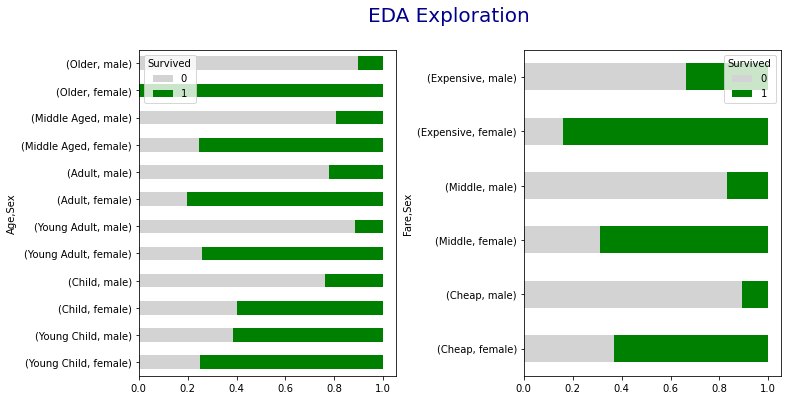

In [17]:
# Exploring from age and fare point of view
bins = [0, 7, 16, 25, 40, 60, 100]
binNames =['Young Child', 'Child', 'Young Adult', 'Adult', 'Middle Aged', 'Older']
binAge = pd.cut(df_train.Age, bins, labels=binNames)

binFare = pd.qcut(df_train.Fare, 3, labels=['Cheap', 'Middle', 'Expensive'])

fig, axes = plt.subplots(1,2, figsize=(11.5, 6))
binVars = [binAge, binFare]
for i in range(2):
    group = df_train.groupby([binVars[i], 'Sex', 'Survived'])
    group = group.size().unstack()
    group = group.div(group.sum(axis=1), axis=0)
    ax = group.plot(kind='barh', stacked=True, color=['lightgray', 'green'], ax=axes[i])

plt.subplots_adjust(left=None, right=None, bottom=None, top=None, hspace=None, wspace=.5);
fig.suptitle('EDA Exploration', **suptitle_param)
plt.show()

# STEP 3 - FEATURE ENGINEERING

### 3.1 Deal with Null values: Simple "Unknown" imputation

In [18]:
class UnknownImputation(BaseEstimator, TransformerMixin):
    '''
    Class for imputing missing string values in a pd.DataFrame using 'Unknown' description.
    
    Parameters
    ----------    
    target_cols : list
        List of columns to impute 'Unknown' value 
    Returns
    -------
    X : Pandas DataFrame
        Dataframe with imputed values in the target column
    '''
    def __init__(self, target_cols):
        assert type(target_cols) == list, 'target_cols should be a list of columns'
        
        self.target_cols = target_cols
    
    def fit(self, X, y=None):
        self.impute_map_ = 'Unknown'
        return self 
    
    def transform(self, X, y=None):
        # make sure that the imputer was fitted
        check_is_fitted(self, 'impute_map_')
        
        X = X.copy(deep = True)
        for col in self.target_cols:
            X[col].fillna(self.impute_map_, inplace=True)
        return X
    
    def fit_transform(self, X, y=None):
        self.fit(X, y)
        return self.transform(X, y)
    
    def predict(self, X):
        self.transform(X)
        return None

### 3.2 Deal with Null values - Group imputation class

In [122]:
class GroupImputer(BaseEstimator, TransformerMixin):
    '''
    Class used for imputing missing values in a pd.DataFrame using either mean or median of a group.
    
    Parameters
    ----------    
    group_cols : list
        List of columns used for calculating the aggregated value 
    target : str
        The name of the column to impute
    metric : str
        The metric to be used for remplacement, can be one of ['mean', 'median']
    Returns
    -------
    X : Pandas DataFrame
        Dataframe with imputed values in the target column
    '''
    def __init__(self, group_cols, target, metric='mean'):
        assert metric in ['mean', 'median'], 'Unrecognized value for metric, should be mean/median'
        assert type(group_cols) == list, 'group_cols should be a list of columns'
        assert type(target) == str, 'target should be a string'
        
        self.group_cols = group_cols
        self.target = target
        self.metric = metric
    
    def fit(self, X, y=None):
        assert pd.isnull(X[self.group_cols]).any(axis=None) == False, 'There are missing values in group_cols'
        
        self.impute_map_ = X.groupby(self.group_cols)[self.target].transform(self.metric)
        return self 
    
    def transform(self, X, y=None):
        # make sure that the imputer was fitted
        check_is_fitted(self, 'impute_map_')
        
        X = X.copy(deep = True)
        X[self.target].fillna(self.impute_map_, inplace=True)
        return X
    
    def fit_transform(self, X, y=None):
        self.fit(X, y)
        return self.transform(X, y)
    
    def predict(self, X, y=None):
        self.transform(X)
        return y

### 3.3 Custom Feature Adition Class

In [20]:
class FeatureMaker(BaseEstimator, TransformerMixin):
    '''
    Class used for add specific custom feature to Titanic Dataset.
    
    Returns
    -------
    X : Pandas DataFrame
        Titanic dataset with new features (Title, Deck, FamilySize).
    '''
    def fit(self, X, y=None):
        return self 
    
    
    def transform(self, X, y=None):
        def defining_title(name, sex):
            #Define the title associate to the person's name.
            if search('Countess|Mme|Mrs', name): return 'Mrs'
            elif search('Mlle|Ms|Miss', name): return 'Miss'
            elif search('Don|Major|Capt|Jonkheer|Rev|Col|Mr|Master', name): return 'Mr'
            elif search('Dr', name):
                if sex == 'male': return 'Mr'
                else: return 'Mrs'
            else: return 'No title'
        
        def contain_a_string(text, list_to_find):
            #Find a string inside a given text.
            string_to_find = '|'.join(list_to_find)
            m = search(string_to_find, text)
            if m: return text[m.start():m.end()]
            return 'Unknown'

        def get_the_deck(text):
            if text == "Unknown": return "Unknown"
            return text[0]

        cabin_list = ['Unknown', 'A', 'B', 'C', 'D', 'E', 'F', 'T', 'G']
        X = X.copy(deep = True)
        
        # Adding new features
        X['Title_P'] = X.apply(lambda row: defining_title(row['Name'], row['Sex']), axis=1)
        #X['Deck'] = X['Cabin'].fillna('Unknown').apply(lambda cab: contain_a_string(cab, cabin_list))
        X['Deck'] = X['Cabin'].fillna('Unknown').apply(lambda cab: get_the_deck(cab))
        X['FamilySize'] = X['SibSp'] + X['Parch']
        
        # Transforming to categorical some columns
        X['Pclass'] = pd.Categorical(X.Pclass, categories=[1, 2, 3], ordered=True)
        X['Sex'] = pd.Categorical(X.Sex, categories=['male', 'female'], ordered=True)
        X['Embarked'] = pd.Categorical(X.Embarked, categories=['Unknown', 'C', 'Q', 'S'], ordered=True)
        X['Title_P'] = pd.Categorical(X.Title_P, categories=['No title', 'Mr', 'Miss', 'Mrs'], ordered=True)
        X['Deck'] = pd.Categorical(X.Deck, categories=cabin_list, ordered=True)

        # Deleting unnecessary features
        X.drop(['Name', 'Ticket', 'Cabin'], axis=1, inplace=True)
        X = pd.get_dummies(X)
        
        return X
    
    
    def fit_transform(self, X, y=None):
        self.fit(X, y)
        return self.transform(X, y)
    
    
    def predict(self, X, y=None):
        return y

### 3.4 Pandas standarized class

In [21]:
class PandasNormalized(BaseEstimator, TransformerMixin):
    '''
    Class used to Normalize a Dataset.
    
    Returns
    -------
    X : Pandas DataFrame
    '''
    def __init__(self):
        self.scalar = MinMaxScaler()
    
    
    def fit(self, X, y=None):
        self.scalar.fit(X)
        return self
    
    
    def transform(self, X, y=None):
        return pd.DataFrame(data = self.scalar.transform(X), columns = X.columns)
    
    
    def fit_transform(self, X, y=None):
        self.fit(X, y)
        return self.transform(X, y)
    
    
    def predict(self, X, y=None):
        return y

# (UNDERSTANDING THE TRANSFORMATION)

### (a) Transform data

In [123]:
##############################################
## GETTING DATA
##############################################
# Create arrays for the features and the target: X, y
X, y = df_train.drop('Survived', axis=1), df_train.Survived
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)
X_train, X_eval, y_train, y_eval = train_test_split(X_train, y_train, test_size=0.2, random_state=SEED)



##############################################
## TRANSFORMING DATA
##############################################
# Column transformation
Categorical_Transformation = make_column_transformer(
    (OneHotEncoder(sparse=False, handle_unknown='ignore'), make_column_selector(dtype_include='category')),
    remainder = MinMaxScaler(), sparse_threshold = 0    
)

# Setup the pipeline steps: steps
steps = [('Unknown_Imp'  , UnknownImputation(target_cols=['Embarked'])),
         ('Group_Imp'    , GroupImputer(group_cols=['Pclass', 'Sex', 'Embarked'], target='Age', metric='mean')),
         ('Feature_Maker', FeatureMaker()),
         ('Scalar'       , PandasNormalized())
        ]

# Create the pipeline: xgb_pipeline
xgb_pipeline = Pipeline(steps)

# Transform data
X_train = xgb_pipeline.fit_transform(X_train)
X_test  = xgb_pipeline.fit_transform(X_test)
X_eval  = xgb_pipeline.fit_transform(X_eval)


# Define the datasets to evaluate the model
evalset = [(X_train, y_train), (X_eval, y_eval)]

### (b) Modeling data

In [23]:
##############################################
## Applying model
##############################################
# Params for xgb.XGBClassifier
xgb_params = dict(objective='binary:logistic', n_estimators=10, use_label_encoder=False, eval_metric='error', 
                  max_depth=3, seed=SEED)

# Setup the pipeline steps: steps
xg_cl = xgb.XGBClassifier(**xgb_params)

# Perform cross-validation
cross_val_scores = cross_val_score(xg_cl, X_train, y_train, cv=3, scoring='roc_auc')

# Print avg. AUC
print("3-fold AUC (on the training set): ", np.mean(cross_val_scores))

# Fit the classifier to the training set
metrics = ['auc', 'logloss']
evalset = [(X_train, y_train), (X_eval, y_eval)]
xg_cl.fit(X_train, y_train, eval_metric=metrics, eval_set=evalset, verbose=0)

# Predict the labels of the test set: preds
preds = xg_cl.predict(X_test)

# evaluate performance - Compute the accuracy: accuracy
score = accuracy_score(y_test, preds)
print('3-fold AUC (on the test     set): ', score)

3-fold AUC (on the training set):  0.8673756826674333
3-fold AUC (on the test     set):  0.7318435754189944


### (c) Learning curve

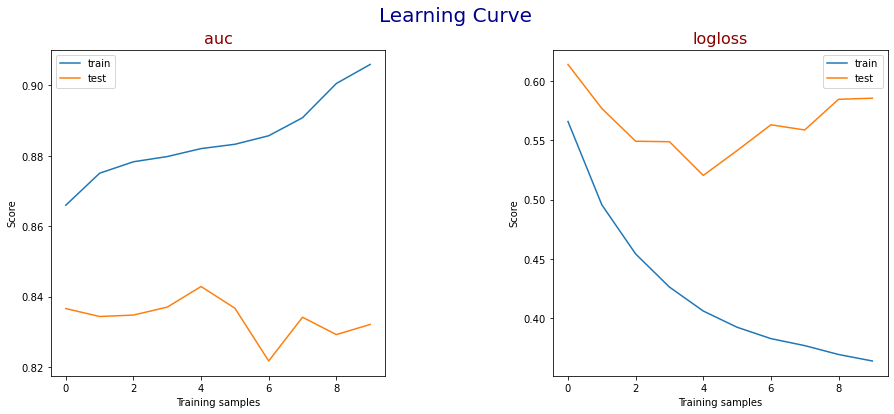

In [24]:
##############################################
## Plotting learning curve
##############################################
# retrieve performance metrics
results = xg_cl.evals_result()

# plot learning curves
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
for ax, metric in zip(axes, metrics):
    ax.plot(results['validation_0'][metric], label='train')
    ax.plot(results['validation_1'][metric], label='test')
    ax.legend()
    ax.set_title(metric, **title_param)
    ax.set_xlabel('Training samples')
    ax.set_ylabel('Score')
fig.suptitle('Learning Curve', **suptitle_param)
plt.subplots_adjust(left=None, right=None, bottom=None, top=None, hspace=None, wspace=.5);
plt.show()

### (d) Relations inside

Number of trees: 10


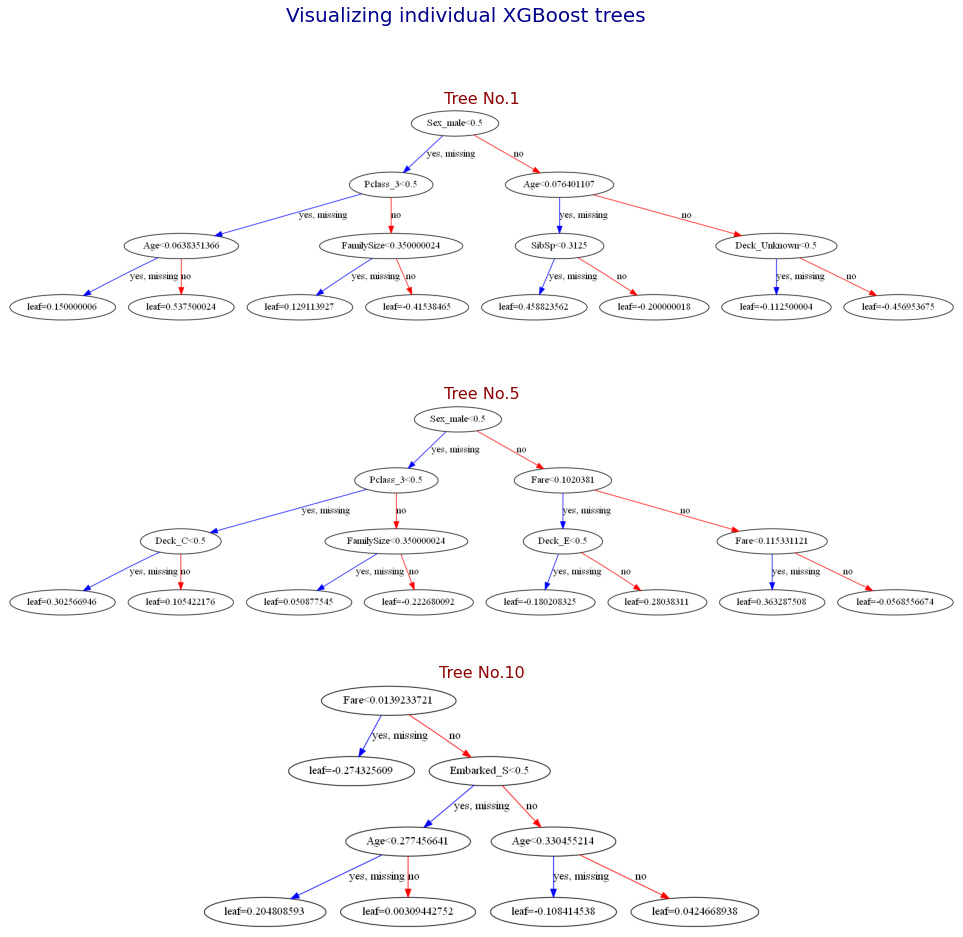

In [25]:
##############################################
## Relations inside
##############################################
print('Number of trees:', xg_cl.get_num_boosting_rounds()) #also xg_cl.n_estimators

# Plot the some tree
n_tree = [0, 4, 9]
size = len(n_tree)
fig, axes = plt.subplots(size, 1, figsize=(17, 5*size))
for i in n_tree:
    ax = axes[n_tree.index(i)]
    xgb.plot_tree(xg_cl, num_trees=i, ax=ax)
    ax.set_title('Tree No.{}'.format(i+1), **title_param)
fig.suptitle('Visualizing individual XGBoost trees', **suptitle_param)
plt.subplots_adjust(left=None, right=None, bottom=None, top=.9, hspace=.2, wspace=None)
plt.show()

### (e) Features Importances

{'Age': 0.0573079,
 'Deck_A': 0.0,
 'Deck_B': 0.0,
 'Deck_C': 0.008910274,
 'Deck_D': 0.0,
 'Deck_E': 0.05302153,
 'Deck_F': 0.0,
 'Deck_G': 0.0,
 'Deck_T': 0.0,
 'Deck_Unknown': 0.112642154,
 'Embarked_C': 0.024911575,
 'Embarked_Q': 0.0,
 'Embarked_S': 0.042634822,
 'Embarked_Unknown': 0.0,
 'FamilySize': 0.041197028,
 'Fare': 0.043718357,
 'Parch': 0.0,
 'Pclass_1': 0.0,
 'Pclass_2': 0.0,
 'Pclass_3': 0.11782892,
 'Sex_female': 0.0,
 'Sex_male': 0.41202617,
 'SibSp': 0.035467252,
 'Title_P_Miss': 0.0,
 'Title_P_Mr': 0.0,
 'Title_P_Mrs': 0.050334,
 'Title_P_No title': 0.0}


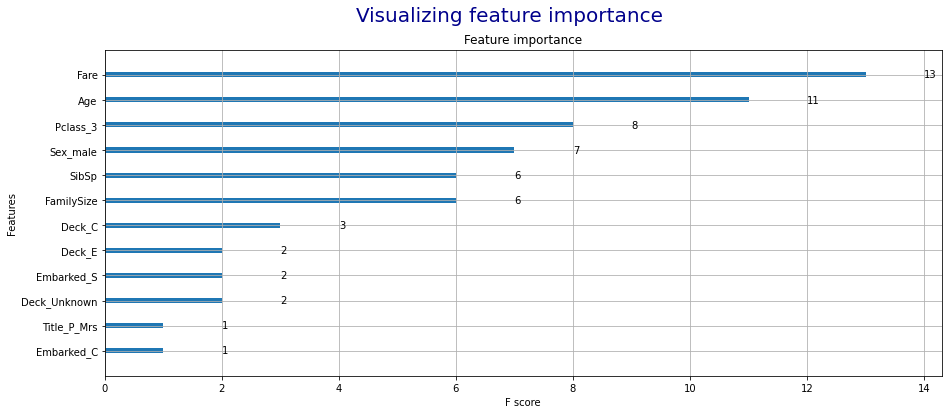

In [26]:
##############################################
## Features Importances
##############################################
#pprint({k:v for k,v in enumerate(xg_cl.feature_importances_)})
pprint({k:v for k,v in zip(xg_cl.get_booster().feature_names, xg_cl.feature_importances_)})

# Plot the feature importances
fig, ax = plt.subplots(figsize=(15, 6))
xgb.plot_importance(xg_cl, ax=ax)
fig.suptitle('Visualizing feature importance', **suptitle_param)
#plt.subplots_adjust(left=.3, right=None, bottom=None, top=None, hspace=None, wspace=None);
plt.show()

# STEP 4 - PREPARING ENVIRONMENT TO APPLY ML

### 4.1 Tunning Environment

In [93]:
class ML_Model(object):
    """
    Encapsulates the creation model, evaluation proccess and the mainly visualization process. 
    """
    SUPTITLE_PARAM = dict(color='darkblue', fontsize=20)
    TITLE_PARAM    = {'color': 'darkred', 'fontsize': 16}
    
    
    def __init__(self, model, metrics, **kwargs):
        self.model = model(**kwargs)
        self.metrics = metrics
        
    def perform_cross_val(self, X_train, y_train, evalset, X_test, y_test, **kwargs):
        # Perform cross-validation
        self.cross_val_scores = cross_val_score(self.model, X_train, y_train, **kwargs)
        
        # Print avg. AUC
        print("3-fold AUC (on the training set): ", np.mean(self.cross_val_scores))
        
        # Fit the classifier to the training set
        self.model.fit(X_train, y_train, eval_metric=self.metrics, eval_set=evalset, verbose=0)

        # Predict the labels of the test set: preds
        self.preds = self.model.predict(X_test)

        # evaluate performance - Compute the accuracy: accuracy
        self.score = accuracy_score(y_test, self.preds)
        print('3-fold AUC (on the test     set): ', self.score)
        
        
    def get_model(self):
        return self.model
    
    
    def plot_learning_curves(self):
        # retrieve performance metrics
        self.results = self.model.evals_result()
        
        # plot learning curves
        fig, axes = plt.subplots(1, 2, figsize=(15, 6))
        for ax, metric in zip(axes, self.METRICS):
            ax.plot(self.results['validation_0'][metric], label='train')
            ax.plot(self.results['validation_1'][metric], label='test')
            ax.legend()
            ax.set_title(metric, **self.TITLE_PARAM)
            ax.set_xlabel('Training samples')
            ax.set_ylabel('Score')
        fig.suptitle('Learning Curve', **self.SUPTITLE_PARAM)
        plt.subplots_adjust(left=None, right=None, bottom=None, top=None, hspace=None, wspace=.5);
        plt.show()
        
        
    def print_num_of_trees(self):
        print('Number of trees:', self.model.get_num_boosting_rounds()) 
                
        
    def plot_relations_inside(self, trees_to_plot=[0, 4, 9]):
        # Plot the some tree
        size = len(trees_to_plot)
        fig, axes = plt.subplots(size, 1, figsize=(17, 5*size))
        for i in trees_to_plot:
            ax = axes[trees_to_plot.index(i)]
            xgb.plot_tree(self.model, num_trees=i, ax=ax)
            ax.set_title('Tree No.{}'.format(i+1), **self.TITLE_PARAM)
        fig.suptitle('Visualizing individual XGBoost trees', **self.SUPTITLE_PARAM)
        plt.subplots_adjust(left=None, right=None, bottom=None, top=.9, hspace=.2, wspace=None)
        plt.show()
        
    
    def get_feature_importances(self):
        #pprint({k:v for k,v in enumerate(self.model.feature_importances_)})
        pprint({k:v for k,v in zip(self.model.get_booster().feature_names, self.model.feature_importances_)})
                
        
    def plot_feature_importance(self):
        # Plot the feature importances
        fig, ax = plt.subplots(figsize=(15, 6))
        xgb.plot_importance(self.model, ax=ax)
        fig.suptitle('Visualizing feature importance', **self.SUPTITLE_PARAM)
        plt.show()

    
    def tunning_model(self, param_grid, X, y, scoring='roc_auc'):
        self.grid_mse = GridSearchCV(estimator=self.model, param_grid=param_grid, scoring=scoring, cv=4, verbose=0)
        self.grid_mse.fit(X, y)
        print("Best parameters found: ", self.grid_mse.best_params_)
        print("Best {} found: ".format(scoring), self.grid_mse.best_score_)
        return self.grid_mse.best_params_

### 4.2 Read and transform data

In [114]:
##############################################
## GETTING DATA
##############################################
# Create arrays for the features and the target: X, y
X, y = df_train.drop('Survived', axis=1), df_train.Survived
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED, stratify=y)
X_train, X_eval, y_train, y_eval = train_test_split(X_train, y_train, test_size=0.2, random_state=SEED, stratify=y_train)



##############################################
## TRANSFORMING DATA
##############################################
# Column transformation
Categorical_Transformation = make_column_transformer(
    (OneHotEncoder(sparse=False, handle_unknown='ignore'), make_column_selector(dtype_include='category')),
    remainder = MinMaxScaler(), sparse_threshold = 0    
)

# Setup the pipeline steps: steps
steps = [('Unknown_Imp'  , UnknownImputation(target_cols=['Embarked'])),
         ('Group_Imp'    , GroupImputer(group_cols=['Pclass', 'Sex', 'Embarked'], target='Age', metric='mean')),
         ('Feature_Maker', FeatureMaker()),
         ('Scalar'       , PandasNormalized())
        ]

# Create the pipeline: xgb_pipeline
xgb_pipeline = Pipeline(steps)

# Transform data
X_train = xgb_pipeline.fit_transform(X_train)
X_test  = xgb_pipeline.transform(X_test)
X_eval  = xgb_pipeline.transform(X_eval)

# define the datasets to evaluate the model
evalset = [(X_train, y_train), (X_eval, y_eval)]

# STEP 5 - APPLYING XGBOOST MODEL

### 5.1 First model approach: XGBoost

In [95]:
##############################################
## Applying model
##############################################
# Params for xgb.XGBClassifier
ml_params = dict(objective='binary:logistic', n_estimators=10, use_label_encoder=False, eval_metric='error', 
                  max_depth=3, seed=SEED)
metrics = ['auc', 'logloss']

# Set the model and parameters
xgb_model = ML_Model(xgb.XGBClassifier, metrics, **ml_params)


##############################################
## Perform cross-validation
##############################################
# Params for cross_val_score
cross_val_params = dict(cv=3, scoring='roc_auc')
 
# Perform cross validation
xgb_model.perform_cross_val(X_train, y_train, evalset, X_test, y_test, **cross_val_params)

3-fold AUC (on the training set):  0.8673756826674333
3-fold AUC (on the test     set):  0.7318435754189944


### 5.2 Model behavior

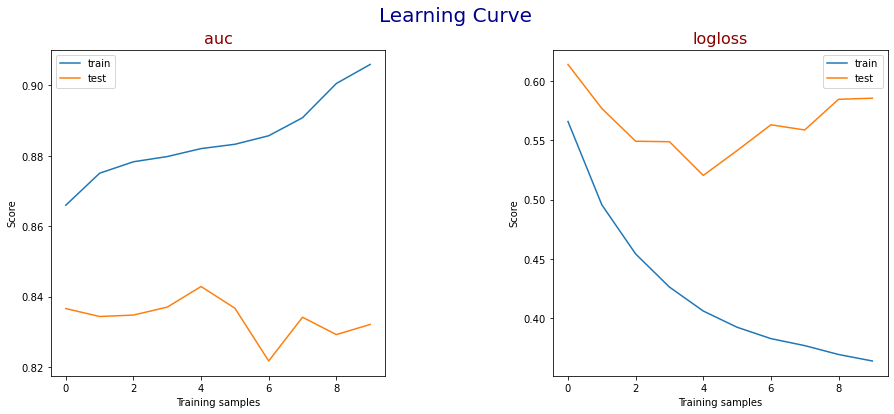

In [76]:
##############################################
## Model behavior
##############################################
xgb_model.plot_learning_curves()

In [77]:
xgb_model.print_num_of_trees()

Number of trees: 10


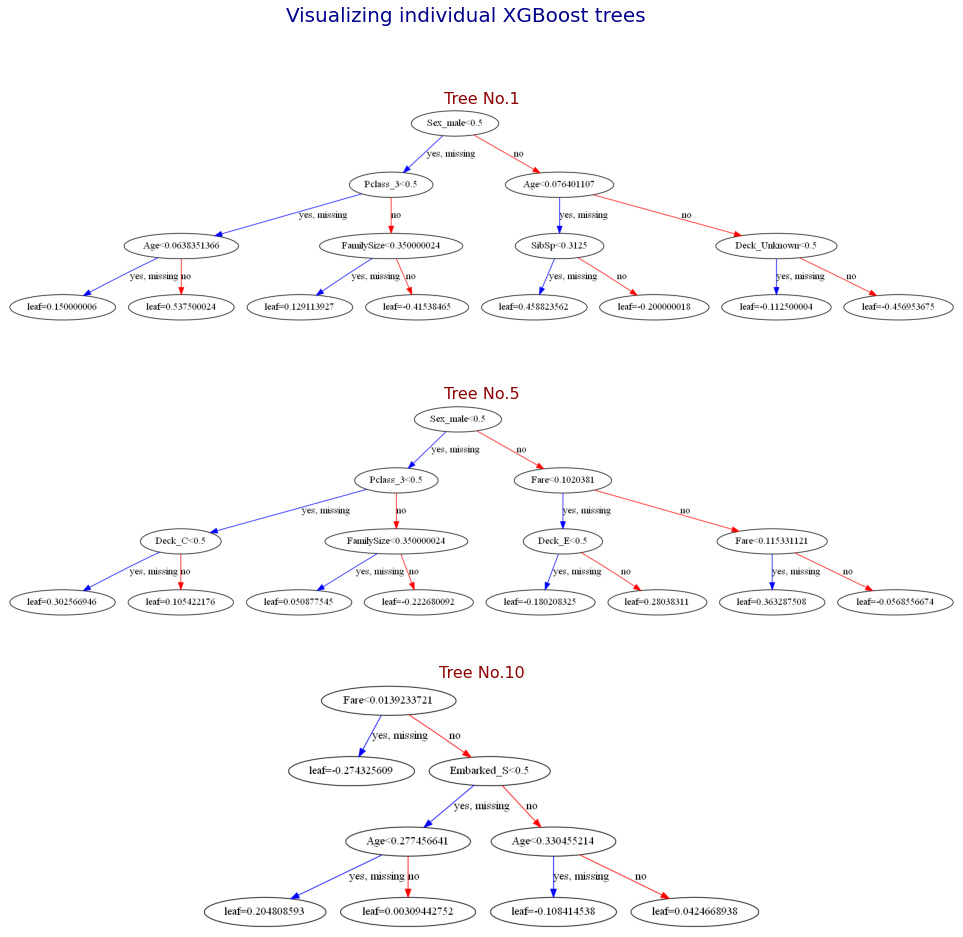

In [78]:
xgb_model.plot_relations_inside([0])

In [79]:
xgb_model.get_feature_importances()

{'Age': 0.0573079,
 'Deck_A': 0.0,
 'Deck_B': 0.0,
 'Deck_C': 0.008910274,
 'Deck_D': 0.0,
 'Deck_E': 0.05302153,
 'Deck_F': 0.0,
 'Deck_G': 0.0,
 'Deck_T': 0.0,
 'Deck_Unknown': 0.112642154,
 'Embarked_C': 0.024911575,
 'Embarked_Q': 0.0,
 'Embarked_S': 0.042634822,
 'Embarked_Unknown': 0.0,
 'FamilySize': 0.041197028,
 'Fare': 0.043718357,
 'Parch': 0.0,
 'Pclass_1': 0.0,
 'Pclass_2': 0.0,
 'Pclass_3': 0.11782892,
 'Sex_female': 0.0,
 'Sex_male': 0.41202617,
 'SibSp': 0.035467252,
 'Title_P_Miss': 0.0,
 'Title_P_Mr': 0.0,
 'Title_P_Mrs': 0.050334,
 'Title_P_No title': 0.0}


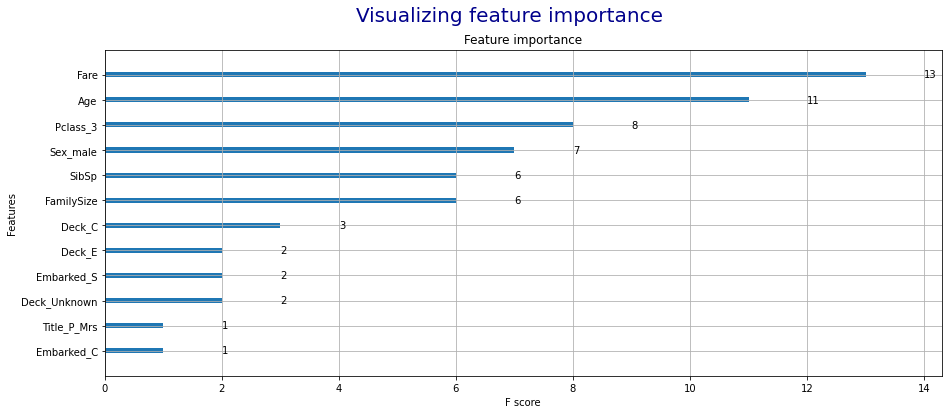

In [71]:
xgb_model.plot_feature_importance()

### 5.3 Tunning the model

In [80]:
##############################################
## Tunning the model
##############################################
param_grid     = {'learning_rate': [0.01, 0.1, 0.5, 0.9, 1],
                  'n_estimators' : [10, 50, 100, 200, 500],
                  'max_depth'    : [3, 5, 10]}
scoring        = 'roc_auc'
#tunning_params = dict(cv=4, verbose=0)

best_params = xgb_model.tunning_model(param_grid, X_train, y_train, scoring)
print(best_params)

Best parameters found:  {'learning_rate': 0.5, 'max_depth': 3, 'n_estimators': 10}
Best roc_auc found:  0.8721698113207548
{'learning_rate': 0.5, 'max_depth': 3, 'n_estimators': 10}


### 5.4 Set best params in the model

3-fold AUC (on the training set):  0.8687906148374843
3-fold AUC (on the test     set):  0.7318435754189944


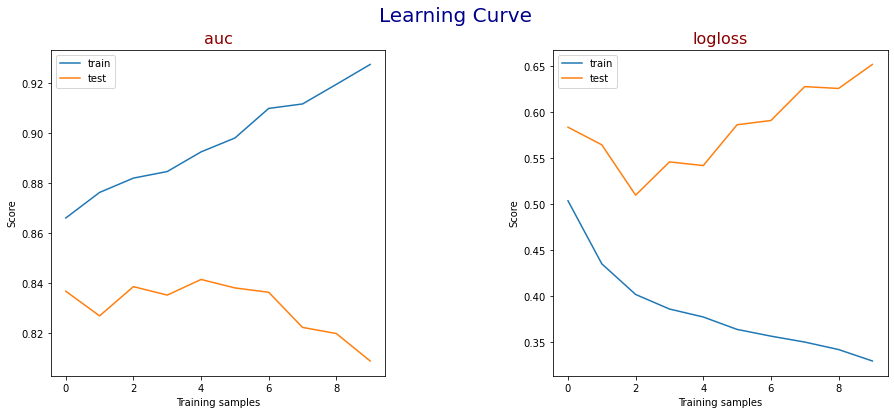

In [82]:
##############################################
## Applying model
##############################################
# Params for xgb.XGBClassifier
ml_params = dict(objective='binary:logistic', n_estimators=10, use_label_encoder=False, eval_metric='error', 
                  learning_rate=0.5, max_depth=3, seed=SEED)
metrics = ['auc', 'logloss']
# Set the model and parameters
xgb_model = ML_Model(xgb.XGBClassifier, metrics, **ml_params)

##############################################
## Perform cross-validation
##############################################
# Params for cross_val_score
model_params = dict(cv=3, scoring='roc_auc')

# Perform cross validation
xgb_model.perform_cross_val(X_train, y_train, evalset, X_test, y_test, **model_params)


##############################################
## Model behavior
##############################################
xgb_model.plot_learning_curves()

# Documentation:
- Titanic - Machine Learning from Disaster: https://www.kaggle.com/c/titanic/overview
- Basic Feature Engineering with the Titanic Data: 
    * https://triangleinequality.wordpress.com/2013/09/08/basic-feature-engineering-with-the-titanic-data/
    * https://triangleinequality.wordpress.com/tag/titanic/
- Titanic tutorial: https://www.kaggle.com/alexisbcook/titanic-tutorial

- When to NOT use XGBoost?: https://www.kaggle.com/discussion/196542
- XGBoost documentation: https://xgboost.readthedocs.io/
- Tunning XGBoost: https://machinelearningmastery.com/tune-xgboost-performance-with-learning-curves/
- XGBoost parameters: https://github.com/dmlc/xgboost/blob/master/doc/parameter.rst

- Sklearn Metrics: https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
- 24 Evaluation Metrics for Binary Classification (And When to Use Them):
    * https://neptune.ai/blog/evaluation-metrics-binary-classification

- Feature importance: 
    * https://machinelearningmastery.com/calculate-feature-importance-with-python/
    * https://mljar.com/blog/feature-importance-xgboost/ (Permutation Based Feature Importance)

- pandas fill null values by the mean of that category: https://stackoverflow.com/questions/62736410/pandas-fill-null-values-by-the-mean-of-that-category
- pandas.core.groupby.DataFrameGroupBy.transform: https://pandas.pydata.org/docs/reference/api/pandas.core.groupby.DataFrameGroupBy.transform.html
- Learning curves: http://rasbt.github.io/mlxtend/user_guide/plotting/plot_learning_curves/